In [6]:
import pandas as pd
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns


In [7]:
def load_and_process_csv(file):
    # Extract the ticker from the filename
    ticker = os.path.basename(file).split('_')[0]
    
    # Load the CSV
    df = pd.read_csv(file, parse_dates=['Date'])
    
    # Ensure the data is sorted by Date
    df = df.sort_values(by='Date')
    
    # Select relevant columns (You can change 'Revenue Growth' to any other metric you're analyzing)
    df['Revenue Growth'] = df['Revenue Growth']
    
    # Calculate quarterly YoY growth (4 quarters = 1 year, hence use .pct_change(4))
    df['YoY_Growth'] = df['Revenue Growth'].pct_change(4) * 100
    
    # Keep only the Date and YoY growth, and rename for identification
    df = df[['Date', 'YoY_Growth']].copy()
    df.rename(columns={'YoY_Growth': ticker + '_YoY_Growth'}, inplace=True)
    
    return df


In [9]:
# Set the directory where your CSV files are stored
csv_directory = 'SP425CSVs/'

# Use glob to find all the CSV files
csv_files = glob.glob(os.path.join(csv_directory, '*_data_with_metrics.csv'))

# Initialize an empty list to store dataframes
dfs = []

# Loop through each file and process it
for file in csv_files:
    df = load_and_process_csv(file)
    dfs.append(df)

# Merge all dataframes on 'Date' column
merged_df = dfs[0]
for df in dfs[1:]:
    merged_df = pd.merge(merged_df, df, on='Date', how='outer')

# Drop rows with NaN values (optional, or you can fillna if needed)
merged_df = merged_df.dropna()


/var/folders/83/3t5wk1pn2fq83ss49zg61zf40000gn/T/ipykernel_95276/529658027.py:15: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df['YoY_Growth'] = df['Revenue Growth'].pct_change(4) * 100
/var/folders/83/3t5wk1pn2fq83ss49zg61zf40000gn/T/ipykernel_95276/529658027.py:15: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df['YoY_Growth'] = df['Revenue Growth'].pct_change(4) * 100


In [10]:
# Calculate Pearson correlation matrix
correlation_matrix = merged_df.set_index('Date').corr(method='pearson')

# Alternatively, you can use spearman: merged_df.set_index('Date').corr(method='spearman')


/opt/anaconda3/lib/python3.12/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/opt/anaconda3/lib/python3.12/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


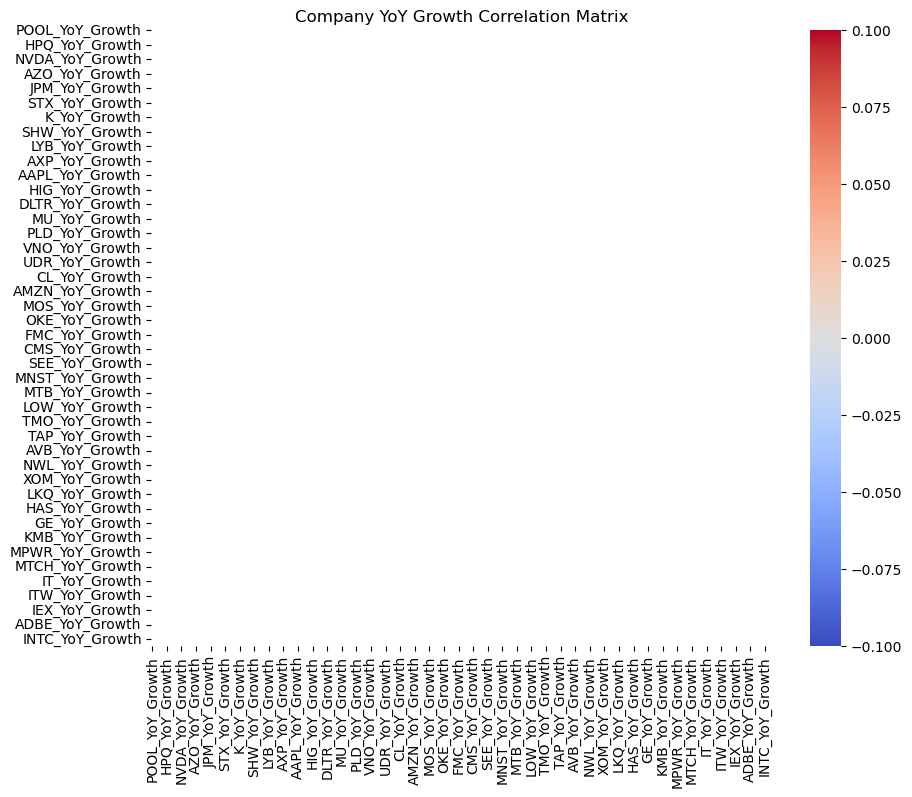

In [12]:
# Plot the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Company YoY Growth Correlation Matrix')
plt.show()


In [13]:
correlation_matrix

,POOL_YoY_Growth,ZION_YoY_Growth,CNP_YoY_Growth,HD_YoY_Growth,SRE_YoY_Growth,CB_YoY_Growth,EL_YoY_Growth,BKNG_YoY_Growth,WMB_YoY_Growth,XRAY_YoY_Growth,...,EBAY_YoY_Growth,BK_YoY_Growth,PNC_YoY_Growth,PHM_YoY_Growth,LYV_YoY_Growth,INTC_YoY_Growth,APH_YoY_Growth,EQIX_YoY_Growth,HBAN_YoY_Growth,AVGO_YoY_Growth
POOL_YoY_Growth,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ZION_YoY_Growth,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CNP_YoY_Growth,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HD_YoY_Growth,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SRE_YoY_Growth,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
INTC_YoY_Growth,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
APH_YoY_Growth,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
EQIX_YoY_Growth,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HBAN_YoY_Growth,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns


In [15]:
# Define the directory where the CSV files are stored
data_directory = 'SP425CSVs/'

# Load all CSV files with the format {ticker}_data_with_metrics.csv
all_files = glob.glob(os.path.join(data_directory, "*_data_with_metrics.csv"))

# Create a dictionary to store data for each company
company_data = {}

for file in all_files:
    ticker = os.path.basename(file).split('_')[0]  # Extract ticker from filename
    df = pd.read_csv(file, parse_dates=['Date'])
    
    # Ensure the data is sorted by date
    df = df.sort_values(by='Date')
    
    # Add to the dictionary
    company_data[ticker] = df


In [21]:
# Function to calculate YoY Growth, modified to check for missing columns
def calculate_yoy_growth(df, metric):
    # Ensure 'Date' is a datetime object
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

    # Drop rows with invalid dates
    df = df.dropna(subset=['Date'])

    # Check if the metric exists in the dataframe
    if metric not in df.columns:
        print(f"Metric '{metric}' not found in data for this company.")
        return pd.Series()  # Return an empty series if the metric is not found

    # Set 'Date' as the index
    df.set_index('Date', inplace=True)

    # Resample the data by quarter
    df_quarterly = df.resample('Q')[metric].sum()

    # Calculate YoY growth
    df_quarterly_yoy = df_quarterly.pct_change(4) * 100

    return df_quarterly_yoy

# Analyze metrics
metrics_to_analyze = ['Revenue Growth', 'P/E Ratio', 'ROE', 'Debt-to-Equity Ratio']
company_growth_data = {}

for ticker, df in company_data.items():
    company_growth_data[ticker] = {}
    
    for metric in metrics_to_analyze:
        yoy_growth = calculate_yoy_growth(df, metric)
        
        # Only add the result if it's not empty
        if not yoy_growth.empty:
            company_growth_data[ticker][metric] = yoy_growth

# Combine YoY growth data into a single DataFrame for correlation analysis
combined_df = pd.DataFrame()

for ticker, growth_metrics in company_growth_data.items():
    for metric in metrics_to_analyze:
        # Check if the metric has been calculated for the company
        if metric in growth_metrics:
            combined_df[f'{ticker}_{metric}'] = growth_metrics[metric]

# Drop rows with missing values
combined_df = combined_df.dropna()

# Perform further analysis (e.g., correlation analysis) on combined_df


KeyError: 'Date'

In [19]:
# Combine YoY growth data into a single DataFrame for correlation analysis
combined_df = pd.DataFrame()

for ticker, growth_metrics in company_growth_data.items():
    for metric in metrics_to_analyze:
        combined_df[f'{ticker}_{metric}'] = growth_metrics[metric]

# Drop rows with missing values (NaN)
combined_df = combined_df.dropna()


KeyError: 'Revenue Growth'

In [ ]:
# Compute correlation matrix for each metric
for metric in metrics_to_analyze:
    relevant_columns = [col for col in combined_df.columns if metric in col]
    
    # Create a correlation matrix for this metric
    correlation_matrix = combined_df[relevant_columns].corr()

    # Plot the correlation matrix as a heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
    plt.title(f'Correlation Matrix for {metric}')
    plt.show()


In [27]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
import time
import os

def get_sp500_sectors():
    sp500 = yf.Ticker("^GSPC")
    return sp500.info.get('sector', [])

def get_sector_companies(sector):
    tickers = yf.Ticker("^SP500-" + sector.upper())
    return list(tickers.info.get('components', []))

def download_stock_data(ticker, start_date, end_date):
    stock = yf.Ticker(ticker)
    data = stock.history(start=start_date, end=end_date)
    return data

def calculate_quarterly_yoy_growth(data):
    quarterly_data = data['Close'].resample('Q').last()
    yoy_growth = quarterly_data.pct_change(periods=4)
    return yoy_growth

def process_company(ticker, start_date, end_date):
    try:
        stock_data = download_stock_data(ticker, start_date, end_date)
        quarterly_yoy_growth = calculate_quarterly_yoy_growth(stock_data)
        return quarterly_yoy_growth
    except Exception as e:
        print(f"Error processing {ticker}: {str(e)}")
        return None

def process_sector(sector, start_date, end_date):
    companies = get_sector_companies(sector)
    if len(companies) <= 3:
        print(f"Skipping {sector} sector: Only {len(companies)} companies found.")
        return None

    print(f"Processing {sector} sector ({len(companies)} companies)...")
    results = {}
    for ticker in companies:
        print(f"  Processing {ticker}...")
        result = process_company(ticker, start_date, end_date)
        if result is not None:
            results[ticker] = result
        time.sleep(1)  # To avoid hitting API rate limits

    if not results:
        print(f"No valid results for {sector} sector.")
        return None

    combined_results = pd.concat(results, axis=1)
    combined_results.columns = pd.MultiIndex.from_tuples(combined_results.columns)
    return combined_results

def main():
    # Calculate the date range for the past 20 years
    end_date = datetime.now()
    start_date = end_date - timedelta(days=365.25 * 20)

    # Get all S&P 500 sectors
    sectors = get_sp500_sectors()

    # Create a directory for output files
    output_dir = "sector_growth_results"
    os.makedirs(output_dir, exist_ok=True)

    # Process each sector
    for sector in sectors:
        sector_results = process_sector(sector, start_date, end_date)
        if sector_results is not None:
            # Save results to CSV
            csv_filename = os.path.join(output_dir, f"{sector}_quarterly_yoy_growth.csv")
            sector_results.to_csv(csv_filename)
            print(f"Results saved to {csv_filename}")

            # Display summary statistics
            print("\nSummary Statistics:")
            print(sector_results.mean().sort_values(ascending=False))
            print("\n" + "="*50 + "\n")

    print("All sectors processed.")

if __name__ == "__main__":
    main()

All sectors processed.


In [28]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
import time
import os

def get_sp500_sectors():
    sp500 = yf.Ticker("^GSPC")
    return sp500.info.get('sector', [])

def get_sector_companies(sector):
    tickers = yf.Ticker("^SP500-" + sector.upper())
    return list(tickers.info.get('components', []))

def download_stock_data(ticker, start_date, end_date):
    stock = yf.Ticker(ticker)
    data = stock.history(start=start_date, end=end_date)
    return data

def calculate_quarterly_yoy_growth(data):
    if data.empty:
        return None
    quarterly_data = data['Close'].resample('Q').last()
    yoy_growth = quarterly_data.pct_change(periods=4)
    return yoy_growth

def process_company(ticker, start_date, end_date):
    try:
        stock_data = download_stock_data(ticker, start_date, end_date)
        quarterly_yoy_growth = calculate_quarterly_yoy_growth(stock_data)
        return quarterly_yoy_growth
    except Exception as e:
        print(f"Error processing {ticker}: {str(e)}")
        return None

def process_sector(sector, start_date, end_date):
    companies = get_sector_companies(sector)
    if len(companies) <= 3:
        print(f"Skipping {sector} sector: Only {len(companies)} companies found.")
        return None

    print(f"Processing {sector} sector ({len(companies)} companies)...")
    results = {}
    for ticker in companies:
        print(f"  Processing {ticker}...")
        result = process_company(ticker, start_date, end_date)
        if result is not None and not result.empty:
            results[ticker] = result
        time.sleep(1)  # To avoid hitting API rate limits

    if not results:
        print(f"No valid results for {sector} sector.")
        return None

    try:
        combined_results = pd.concat(results, axis=1)
        combined_results.columns = pd.MultiIndex.from_tuples(combined_results.columns)
        return combined_results
    except ValueError as e:
        print(f"Error combining results for {sector} sector: {str(e)}")
        return None

def main():
    # Calculate the date range for the past 20 years
    end_date = datetime.now()
    start_date = end_date - timedelta(days=365.25 * 20)

    # Get all S&P 500 sectors
    sectors = get_sp500_sectors()

    # Create a directory for output files
    output_dir = "sector_growth_results"
    os.makedirs(output_dir, exist_ok=True)

    # Process each sector
    for sector in sectors:
        sector_results = process_sector(sector, start_date, end_date)
        if sector_results is not None:
            # Save results to CSV
            csv_filename = os.path.join(output_dir, f"{sector}_quarterly_yoy_growth.csv")
            sector_results.to_csv(csv_filename)
            print(f"Results saved to {csv_filename}")

            # Display summary statistics
            print("\nSummary Statistics:")
            print(sector_results.mean().sort_values(ascending=False))
            print("\n" + "="*50 + "\n")
        else:
            print(f"No results to save for {sector} sector.")
            print("\n" + "="*50 + "\n")

    print("All sectors processed.")

if __name__ == "__main__":
    main()

All sectors processed.
